# STAC Data Loader

This uses the generic `pystac_client` interface to query the Microsoft Planetary Computer STAC API.
On this server, a collection of Land-Cover annotated Landsat imagery provided by Natural Resources Canada (NRCan) is available.
The images are represented by Cloud-Optimized GeoTiff (COG), and hosted on AWS NRCan servers.

We query this collection with relevant filters, and then load them using `torchdata` `DataPipe`.
The advantage of this iterator wrapper, contrary to a custom `torch` `Dataset` class, is that it allows chaining
transformation operations and aggregating the results with other datasets.

In [82]:
from datetime import datetime, timezone

import pystac_client
import planetary_computer
import rioxarray
import torchdata
from rasterio.warp import transform_bounds
from torchgeo.datasets.utils import BoundingBox

## Define our search criteria to query the STAC API

In [83]:
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

# land-cover data from NRCan in Planetary-Computer
# examples:
#   - https://planetarycomputer.microsoft.com/api/stac/v1/collections/nrcan-landcover/items/CAN_LC_2015_CAL_13_15
col = ["nrcan-landcover"]
toi = [
    datetime(2015, 1, 1, tzinfo=timezone.utc),
    datetime(2020, 2, 1, tzinfo=timezone.utc),
]
# Québec, Canada - Surrounding Montréal and part of Vermont/New-Hampshire, USA
aoi_mtl_epsg3978 = [1600390, -285480, 1900420, 14550]
aoi_mtl_epsg4326 = transform_bounds("epsg:3978", "epsg:4326", *aoi_mtl_epsg3978)
# Québec, Québec City
aoi_qcc_epsg3978 = [1600390, 14550, 1900420, 314580]
aoi_qcc_epsg4326 = transform_bounds("epsg:3978", "epsg:4326", *aoi_qcc_epsg3978)
aoi = BoundingBox(*aoi_mtl_epsg4326, 0, 0) | BoundingBox(*aoi_qcc_epsg4326, 0, 0)
aoi = aoi[0:4]

print("COL", col)
print("AOI", aoi)
print("TOI", toi)

COL ['nrcan-landcover']
AOI [-75.07114805923383, 45.78709440860858, -70.27246530095542, 49.25983420104638]
TOI [datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2020, 2, 1, 0, 0, tzinfo=datetime.timezone.utc)]


## Perform the query and validate we found some matches

In [84]:
catalog = pystac_client.Client.open(stac_url)
items = catalog.search(
    limit=10,
    bbox=aoi,
    datetime=toi,
    collections=col,
)
found_items = list(items.items())
found_items

[<Item id=CAN_LC_2015_CAL_14_15>,
 <Item id=CAN_LC_2015_CAL_14_14>,
 <Item id=CAN_LC_2015_CAL_13_15>,
 <Item id=CAN_LC_2015_CAL_13_14>,
 <Item id=CAN_LC_2015_CAL_12_15>,
 <Item id=CAN_LC_2015_CAL_12_14>]

View the classes available on this land-cover imagery.
The classes are defined using the [STAC Label extension](https://github.com/stac-extensions/label) with the `label:classes` property.
There are many other properties available, but we don't use them for this example.

In [85]:
classes = found_items[0].properties["label:classes"][0]["classes"]
cls_map = {i: label for i, label in enumerate(classes)}
cls_map

{0: 'Temperate or sub-polar needleleaf forest',
 1: 'Sub-polar taiga needleleaf forest',
 2: 'Temperate or sub-polar broadleaf deciduous forest',
 3: 'Mixed forest',
 4: 'Temperate or sub-polar shrubland',
 5: 'Temperate or sub-polar grassland',
 6: 'Sub-polar or polar shrubland-lichen-moss',
 7: 'Sub-polar or polar grassland-lichen-moss',
 8: 'Sub-polar or polar barren-lichen-moss',
 9: 'Wetland',
 10: 'Cropland',
 11: 'Barren lands',
 12: 'Urban',
 13: 'Water',
 14: 'Snow and Ice'}

## Extract the STAC Asset URLs of the target imagery

For each item, open the `landcover` asset of interest provided with this annotated imagery. Classes are applied pixel-wise.

**Note 1**
Each STAC item can define their own combination of assets.
We cannot guess automatically which one is important for each use-case.
It is up to the user to extract the relevant asset(s) that are provided by each STAC Item.

**Note 2**
The Microsoft Planetary Computer specifically requires to "sign" each URL item being queried to allow their download.
This is also something to consider when interacting various STAC APIs.
Their authentication and authorization criteria are not entirely compatible.

In [86]:
signed_items = [
    planetary_computer.sign(item.assets["landcover"])
    for item in found_items
]

asset_href = signed_items[0].href
xarray_data = rioxarray.open_rasterio(asset_href)
xarray_data

<xarray.DataArray (band: 1, y: 10001, x: 10001)>
[100020001 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 1.9e+06 1.9e+06 1.9e+06
  * y            (y) float64 1.454e+04 1.45e+04 ... -2.854e+05 -2.855e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

## Visualize the imagery and classes for validation.

**Note**
 USA area is not available from this data produced by Canada (`no-data` values).
 Only the Canada/Québec portion with land-cover classes is visible.

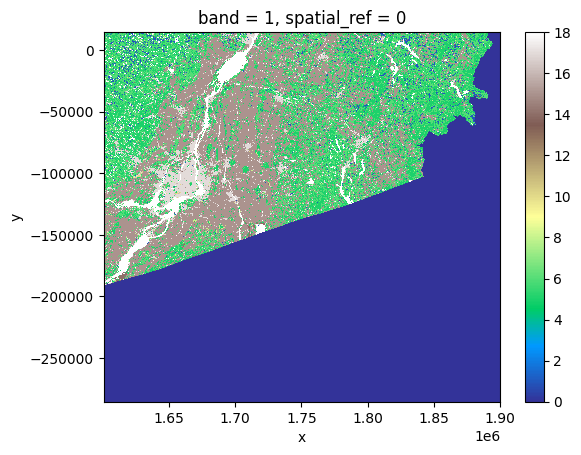

In [87]:
xarray_data.squeeze().plot.imshow(cmap="terrain")  # 'squeeze' because color is 1D (classes), not RGB(A)

## Generate image chips from our source data

Because models cannot take the full image above as input, and even less the full set of all images stitched together,
we must generate chips (a.k.a. patches or tiles) using a sliding window. Because this is a fairly common operation, we delegate
the operation to `xbatcher` which will slice the samples for us with the desired dimensions.

**Note**
It is entirely possible to extract using other approaches. The important aspect is to make it work with whichever resources
are available on your machine. Here, we extract only 1 sample for displaying it. However, you most probably will need to
generate a `batch` of samples to take advantage of GPU speedups when training a model.
For this, other parameters such as `batch_dims` can be used.
Also, it is often necessary to use some stride (overlapping tiles from the sliding window), to avoid some artifacts on tile edges.
For this, `input_overlap` can be used.

More examples available in:
- [https://xbatcher.readthedocs.io/en/latest/demo.html](https://xbatcher.readthedocs.io/en/latest/demo.html)
- [https://zen3geo.readthedocs.io/en/latest/api.html](https://zen3geo.readthedocs.io/en/latest/api.html)
- [https://zen3geo.readthedocs.io/en/latest/walkthrough.html](https://zen3geo.readthedocs.io/en/latest/walkthrough.html)

In [75]:
# WARNING: ensure this is imported, otherwise "slice_with_xbatcher" property won't be registered!
from zen3geo.datapipes import XbatcherSlicer  # noqa

xarray_iter = [rioxarray.open_rasterio(item.href) for item in signed_items]
data_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=xarray_iter)
dp_xarray = data_pipe.slice_with_xbatcher(input_dims={"x": 256, "y": 256})
dp_xarray

XbatcherSlicerIterDataPipe

In [79]:
chip = next(iter(dp_xarray))  # NOTE: to use as a DataLoader in a training pipeline, replace by for-loop
chip

<xarray.DataArray (band: 1, y: 256, x: 256)>
array([[[5, 5, 6, ..., 6, 5, 5],
        [5, 5, 6, ..., 6, 5, 5],
        [5, 6, 6, ..., 6, 6, 5],
        ...,
        [5, 5, 5, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 1.608e+06 1.608e+06
  * y            (y) float64 1.454e+04 1.45e+04 ... 6.915e+03 6.885e+03
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

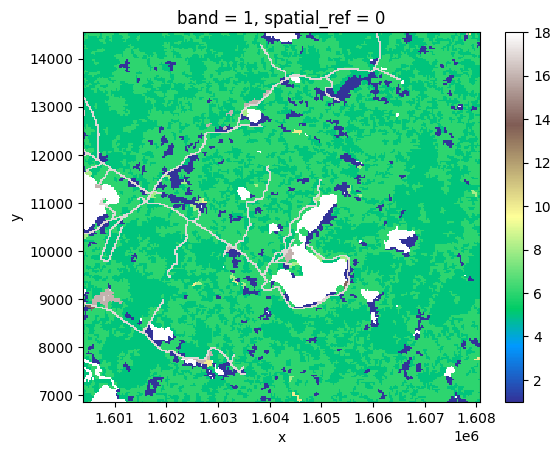

In [80]:
chip.squeeze().plot.imshow(cmap="terrain")

## Obtain non-annotated imagery data

Note that only the annotated classes were retrieved above.
If we want to use the pixel-wise labeling in a training pipeline,
we need to retrieve actual satellite imagery (without the classes) to train a model.
However, that imagery is not available within the same STAC Collection as the previous labels.
Let's retrieve some other data sources.

In [88]:
items = catalog.search(
    limit=10,
    bbox=aoi,       # reuse the same AOI, since we are interested in the same area as previously obtained labels
    datetime=toi,   # reuse the same TOI, since things could have changed since, we cannot rely on too recent images compared to labels
    collections=["landsat-c2-l2"],
)
found_items = list(items.items())
found_items

[<Item id=LC08_L2SP_012028_20200130_02_T1>,
 <Item id=LC08_L2SP_012027_20200130_02_T1>,
 <Item id=LC08_L2SP_012026_20200130_02_T1>,
 <Item id=LE07_L2SP_013028_20200129_02_T1>,
 <Item id=LE07_L2SP_013027_20200129_02_T1>,
 <Item id=LE07_L2SP_013026_20200129_02_T1>,
 <Item id=LC08_L2SP_014028_20200128_02_T1>,
 <Item id=LC08_L2SP_014027_20200128_02_T1>,
 <Item id=LC08_L2SP_014026_20200128_02_T1>,
 <Item id=LC08_L2SP_014025_20200128_02_T1>,
 <Item id=LE07_L2SP_015028_20200127_02_T2>,
 <Item id=LE07_L2SP_015027_20200127_02_T2>,
 <Item id=LE07_L2SP_015026_20200127_02_T2>,
 <Item id=LC08_L2SP_016028_20200126_02_T2>,
 <Item id=LC08_L2SP_016027_20200126_02_T2>,
 <Item id=LC08_L2SP_016026_20200126_02_T2>,
 <Item id=LC08_L2SP_016025_20200126_02_T2>,
 <Item id=LE07_L2SP_017026_20200125_02_T2>,
 <Item id=LE07_L2SP_012028_20200122_02_T2>,
 <Item id=LE07_L2SP_012027_20200122_02_T1>,
 <Item id=LE07_L2SP_012026_20200122_02_T1>,
 <Item id=LC08_L2SP_013028_20200121_02_T1>,
 <Item id=LC08_L2SP_013027_20200

## Combine the images with the annotations

Now that we have both references, we need to combine the imagery with the labels using the intersection of the bounding boxes
between the two collections. This will allow us to define a training pipeline were the model receives the input imagery, and
attempts to learn predicting the target labels.
